[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shhommychon/mnist_generative_practice/blob/master/GAN.ipynb)

# MNIST GAN 학습

## 환경설정

- PyTorch 버젼 다운그레이드 코드로 인해 세션이 자동으로 한번 꺼질 예정입니다. 다시 실행하면 됩니다.

In [1]:
# 현 CUDA 버젼 확인
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
# 파이썬 버젼 고정
import torch

# 현 PyTorch 버젼 확인
if torch.__version__.split('+')[0] != "1.11.0":
    print(f"Current PyTorch version is {torch.__version__}, downgrading to 1.11.0")

    # PyTorch 제거
    !pip uninstall torch torchvision -y

    # PyTorch 1.11.0 설치
    !pip install torch==1.11.0 torchvision==0.12.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

    # 런타임 강제 재시작
    import os
    os.kill(os.getpid(), 9)
else:
    print("PyTorch version is already 1.11.0")

PyTorch version is already 1.11.0


In [3]:
!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 4), reused 15 (delta 3), pack-reused 0
Receiving objects: 100% (16/16), 7.91 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
!apt install megatools

# mnist_feature_extractor.dth
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 0s (679 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 121671 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


## 실습 코드

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

### MNIST 데이터셋 다운로드 및 불러오기

- 다운로드 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#downloading-datasets)
- 불러오기 코드 원본: [devnson/mnist_pytorch](https://github.com/devnson/mnist_pytorch?tab=readme-ov-file#splitting-datasets)

In [6]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


### 모델 및 손실함수/옵티마이저 등 설정

In [7]:
# GAN 학습 보조용 사전학습 MNIST 분류기
from models.classifier import MNISTClassifier

c_model = MNISTClassifier()
c_model.feature_extractor.load_state_dict(torch.load("mnist_feature_extractor.dth"))
c_model.classifier.load_state_dict(torch.load("mnist_classifier.dth"))

if (torch.cuda.is_available()): c_model.cuda()

# freeze
for param in c_model.parameters(): param.requires_grad = False

c_model

MNISTClassifier(
  (feature_extractor): ConvFeatExtractor(
    (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (linear): Linear(in_features=3136, out_features=128, bias=True)
    (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (relu): ReLU()
  )
  (classifier): ClassifierHead(
    (dropout): SoftDropout(
      (dropouts): ModuleList(
        (0): Dropout(p=0.5, inplace=False)
        (1): Dropout(p=0.5, inplace=False)
        (2): Dropout(p=0.5, inplace=False)
        (3): Dropout(p=0.5, inplace=False)
        (4): Dropout(p=0.5, inplace=False)
      )
    )
    (relu): ReLU()
    (linear): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [8]:
from models.gan import MNISTGan

g_model = MNISTGan()

if (torch.cuda.is_available()): g_model.cuda()

g_model

MNISTGan(
  (label_emb): Embedding(10, 4)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer): Linear(in_features=132, out_features=784, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [9]:
from models.gan import Discriminator

d_model = Discriminator()

if (torch.cuda.is_available()): d_model.cuda()

d_model

Discriminator(
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [10]:
adversarial_loss = nn.BCELoss()
classification_loss = nn.CrossEntropyLoss()

lr=0.002
g_optimizer = torch.optim.Adam(g_model.parameters(), lr=lr)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr=lr)

decay_rate = 0.99
g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=decay_rate)
d_scheduler = torch.optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=decay_rate)

max_epochs = 100
best_val_loss = 100
max_patience = 10

### 이미지 생성 코드

- 학습 중간 확인 용도

In [11]:
def generate_images(model, latent, class_label):
    model.eval()
    with torch.no_grad():
        latent = latent.to(device)
        class_label = class_label.to(device)
        images = model(latent, class_label)
    return images

### 모델 학습 코드


Epoch: 1/100,
	Dis Train Loss: 0.39423883
		real loss: 0.20706653
		fake loss: 0.18717231
	Gen Train Loss: 9.48662707
		adversarial loss: 3.71805193
		classification loss: 0.57685751
	Gen Val Loss: 4.63689055
		adversarial loss: 4.04482792
		classification loss: 0.05920626


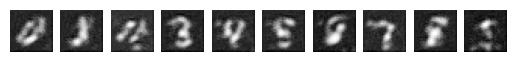

	Saving the model state dictionary for Epoch: 1 with Validation loss: 4.63689055

Epoch: 2/100,
	Dis Train Loss: 0.40554084
		real loss: 0.22584814
		fake loss: 0.17969270
	Gen Train Loss: 5.66913887
		adversarial loss: 3.97121768
		classification loss: 0.16979212
	Gen Val Loss: 4.14385586
		adversarial loss: 3.62224844
		classification loss: 0.05216074


<Figure size 640x480 with 0 Axes>

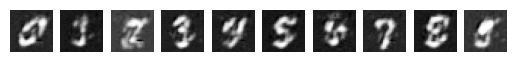

	Saving the model state dictionary for Epoch: 2 with Validation loss: 4.14385586

Epoch: 3/100,
	Dis Train Loss: 0.35571388
		real loss: 0.19435304
		fake loss: 0.16136084
	Gen Train Loss: 5.39212587
		adversarial loss: 3.91757646
		classification loss: 0.14745494
	Gen Val Loss: 4.29934502
		adversarial loss: 3.77295478
		classification loss: 0.05263902


<Figure size 640x480 with 0 Axes>

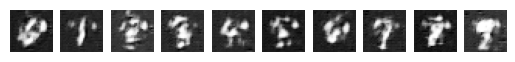

	Loss not decreased. Will wait for 9 more epochs...

Epoch: 4/100,
	Dis Train Loss: 0.41822755
		real loss: 0.23760208
		fake loss: 0.18062547
	Gen Train Loss: 4.93263004
		adversarial loss: 3.68925139
		classification loss: 0.12433787
	Gen Val Loss: 4.29666688
		adversarial loss: 3.75135126
		classification loss: 0.05453156


<Figure size 640x480 with 0 Axes>

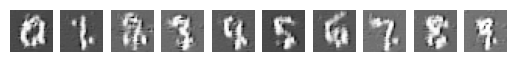

	Loss not decreased. Will wait for 8 more epochs...

Epoch: 5/100,
	Dis Train Loss: 0.49848248
		real loss: 0.28716546
		fake loss: 0.21131702
	Gen Train Loss: 4.58750338
		adversarial loss: 3.43920590
		classification loss: 0.11482975
	Gen Val Loss: 3.23893668
		adversarial loss: 2.58824606
		classification loss: 0.06506906


<Figure size 640x480 with 0 Axes>

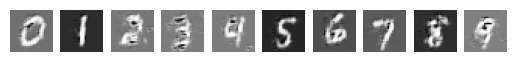

	Saving the model state dictionary for Epoch: 5 with Validation loss: 3.23893668

Epoch: 6/100,
	Dis Train Loss: 0.50909551
		real loss: 0.28836663
		fake loss: 0.22072888
	Gen Train Loss: 3.97878999
		adversarial loss: 3.01400017
		classification loss: 0.09647898
	Gen Val Loss: 2.66269312
		adversarial loss: 2.49283014
		classification loss: 0.01698630


<Figure size 640x480 with 0 Axes>

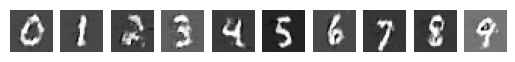

	Saving the model state dictionary for Epoch: 6 with Validation loss: 2.66269312

Epoch: 7/100,
	Dis Train Loss: 0.52590129
		real loss: 0.29499425
		fake loss: 0.23090704
	Gen Train Loss: 3.85002530
		adversarial loss: 2.93387549
		classification loss: 0.09161498
	Gen Val Loss: 2.77771871
		adversarial loss: 2.52508935
		classification loss: 0.02526294


<Figure size 640x480 with 0 Axes>

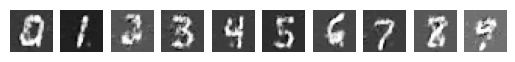

	Loss not decreased. Will wait for 9 more epochs...

Epoch: 8/100,
	Dis Train Loss: 0.55105827
		real loss: 0.30765757
		fake loss: 0.24340070
	Gen Train Loss: 3.58480921
		adversarial loss: 2.74465964
		classification loss: 0.08401496
	Gen Val Loss: 2.38372234
		adversarial loss: 2.13197750
		classification loss: 0.02517449


<Figure size 640x480 with 0 Axes>

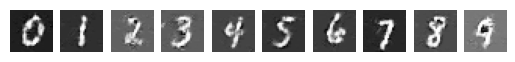

	Saving the model state dictionary for Epoch: 8 with Validation loss: 2.38372234

Epoch: 9/100,
	Dis Train Loss: 0.55654967
		real loss: 0.31241901
		fake loss: 0.24413066
	Gen Train Loss: 3.38932464
		adversarial loss: 2.61604488
		classification loss: 0.07732798
	Gen Val Loss: 2.38289198
		adversarial loss: 2.25316171
		classification loss: 0.01297303


<Figure size 640x480 with 0 Axes>

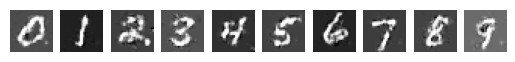

	Saving the model state dictionary for Epoch: 9 with Validation loss: 2.38289198

Epoch: 10/100,
	Dis Train Loss: 0.56537879
		real loss: 0.31529977
		fake loss: 0.25007902
	Gen Train Loss: 3.25834863
		adversarial loss: 2.52779284
		classification loss: 0.07305558
	Gen Val Loss: 2.60114819
		adversarial loss: 2.48524688
		classification loss: 0.01159013


<Figure size 640x480 with 0 Axes>

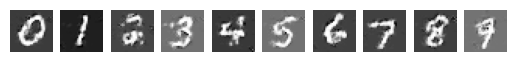

	Loss not decreased. Will wait for 9 more epochs...

Epoch: 11/100,
	Dis Train Loss: 0.56686814
		real loss: 0.31601679
		fake loss: 0.25085135
	Gen Train Loss: 3.32798675
		adversarial loss: 2.58576651
		classification loss: 0.07422202
	Gen Val Loss: 2.53265821
		adversarial loss: 2.37926314
		classification loss: 0.01533951


<Figure size 640x480 with 0 Axes>

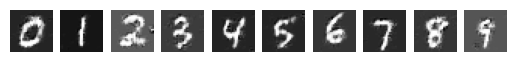

	Loss not decreased. Will wait for 8 more epochs...

Epoch: 12/100,
	Dis Train Loss: 0.53794148
		real loss: 0.29983632
		fake loss: 0.23810516
	Gen Train Loss: 3.32968815
		adversarial loss: 2.63477202
		classification loss: 0.06949161
	Gen Val Loss: 2.77350192
		adversarial loss: 2.56832921
		classification loss: 0.02051727


<Figure size 640x480 with 0 Axes>

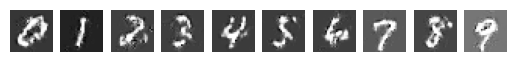

	Loss not decreased. Will wait for 7 more epochs...

Epoch: 13/100,
	Dis Train Loss: 0.52409425
		real loss: 0.29164005
		fake loss: 0.23245419
	Gen Train Loss: 3.30889333
		adversarial loss: 2.64191666
		classification loss: 0.06669767
	Gen Val Loss: 2.76283566
		adversarial loss: 2.67303271
		classification loss: 0.00898029


<Figure size 640x480 with 0 Axes>

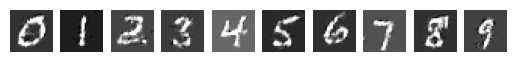

	Loss not decreased. Will wait for 6 more epochs...

Epoch: 14/100,
	Dis Train Loss: 0.51905594
		real loss: 0.29129208
		fake loss: 0.22776385
	Gen Train Loss: 3.39608149
		adversarial loss: 2.71756370
		classification loss: 0.06785178
	Gen Val Loss: 2.86288851
		adversarial loss: 2.65383103
		classification loss: 0.02090575


<Figure size 640x480 with 0 Axes>

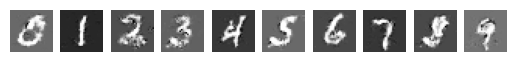

	Loss not decreased. Will wait for 5 more epochs...

Epoch: 15/100,
	Dis Train Loss: 0.51602532
		real loss: 0.29008576
		fake loss: 0.22593957
	Gen Train Loss: 3.35934623
		adversarial loss: 2.70176410
		classification loss: 0.06575821
	Gen Val Loss: 3.15345929
		adversarial loss: 3.08339720
		classification loss: 0.00700621


<Figure size 640x480 with 0 Axes>

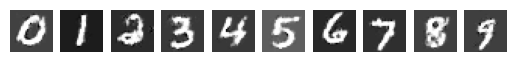

	Loss not decreased. Will wait for 4 more epochs...

Epoch: 16/100,
	Dis Train Loss: 0.50721474
		real loss: 0.28562294
		fake loss: 0.22159180
	Gen Train Loss: 3.38188790
		adversarial loss: 2.74133985
		classification loss: 0.06405481
	Gen Val Loss: 3.14619868
		adversarial loss: 2.93573457
		classification loss: 0.02104641


<Figure size 640x480 with 0 Axes>

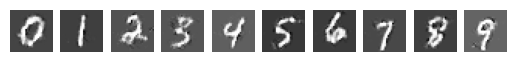

	Loss not decreased. Will wait for 3 more epochs...

Epoch: 17/100,
	Dis Train Loss: 0.49372104
		real loss: 0.27952658
		fake loss: 0.21419446
	Gen Train Loss: 3.44855674
		adversarial loss: 2.81944125
		classification loss: 0.06291155
	Gen Val Loss: 2.88483988
		adversarial loss: 2.76824529
		classification loss: 0.01165946


<Figure size 640x480 with 0 Axes>

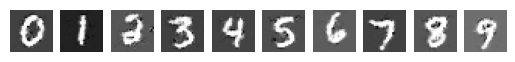

	Loss not decreased. Will wait for 2 more epochs...

Epoch: 18/100,
	Dis Train Loss: 0.49361552
		real loss: 0.27978401
		fake loss: 0.21383151
	Gen Train Loss: 3.39614228
		adversarial loss: 2.78213159
		classification loss: 0.06140107
	Gen Val Loss: 2.85127273
		adversarial loss: 2.75942947
		classification loss: 0.00918433


<Figure size 640x480 with 0 Axes>

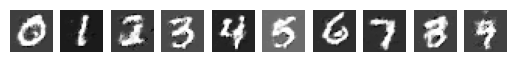

	Loss not decreased. Will wait for 1 more epochs...

Epoch: 19/100,
	Dis Train Loss: 0.48346686
		real loss: 0.27358522
		fake loss: 0.20988164
	Gen Train Loss: 3.46395340
		adversarial loss: 2.84618603
		classification loss: 0.06177674
	Gen Val Loss: 2.98311210
		adversarial loss: 2.86884095
		classification loss: 0.01142712


<Figure size 640x480 with 0 Axes>

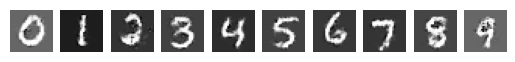

	Loss not decreased. Will wait for 0 more epochs...


<Figure size 640x480 with 0 Axes>

In [12]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"
patience = max_patience
for epoch in range(max_epochs):
    total_train_loss = {
        "d_loss_real": 0,
        "d_loss_fake": 0,
        "d_loss_total": 0,

        "g_loss_adv": 0,
        "g_loss_class": 0,
        "g_loss_total": 0,
    }
    total_val_loss = {
        "g_loss_adv": 0,
        "g_loss_class": 0,
        "g_loss_total": 0,
    }

    g_model.train()
    d_model.train()

    # training
    for iter, (real_image, class_label) in enumerate(train_dataloader):
        real_image = real_image.to(device)
        class_label = class_label.to(device)

        # Discriminator labels for real and fake data
        batch_size = real_image.size(0)
        real_label = torch.ones(batch_size, 1).to(device)
        fake_label = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator on real data
        d_optimizer.zero_grad()

        ## train on real data
        d_loss_real = adversarial_loss(
                            d_model(real_image), real_label)

        ## train on fake data
        z_noise = torch.randn(batch_size, 128).to(device)
        fake_noise_image = g_model(z_noise, class_label)
        d_loss_fake = adversarial_loss(
                            d_model(fake_noise_image.detach()), fake_label)

        # Update the discriminator weights
        this_d_loss = d_loss_real + d_loss_fake
        this_d_loss.backward()
        d_optimizer.step()

        # Train the generator
        g_optimizer.zero_grad()

        ## adversarial loss
        g_loss_adv = adversarial_loss(
                            d_model(fake_noise_image), real_label)

        ## reconstruction loss
        class_pred = c_model(fake_noise_image)
        g_loss_class = classification_loss(class_pred, class_label)

        # Update the generator weights
        this_g_loss = 1 * g_loss_adv + 10 * g_loss_class
        this_g_loss.backward()
        g_optimizer.step()


        total_train_loss["d_loss_real"] += d_loss_real.item()
        total_train_loss["d_loss_fake"] += d_loss_fake.item()
        total_train_loss["d_loss_total"] += this_d_loss.item()

        total_train_loss["g_loss_adv"] += g_loss_adv.item()
        total_train_loss["g_loss_class"] += g_loss_class.item()
        total_train_loss["g_loss_total"] += this_g_loss.item()

    # Step the learning rate schedulers
    g_scheduler.step()
    d_scheduler.step()

    total_train_loss = { k: train_loss / (iter + 1) for k, train_loss
                                                in total_train_loss.items() }

    # validation
    g_model.eval()
    d_model.eval()

    for iter, (real_image, class_label) in enumerate(val_dataloader):
        real_image = real_image.to(device)
        class_label = class_label.to(device)

        # Evaluate the generator
        batch_size = real_image.size(0)
        real_label = torch.ones(batch_size, 1).to(device)
        z_noise = torch.randn(batch_size, 128).to(device)
        fake_noise_image = g_model(z_noise, class_label)

        ## adversarial loss
        g_loss_adv = adversarial_loss(
                        d_model(fake_noise_image), real_label)

        ## reconstruction loss
        class_pred = c_model(fake_noise_image)
        g_loss_class = classification_loss(class_pred, class_label)

        # Update the generator weights
        this_g_loss = 1 * g_loss_adv + 10 * g_loss_class


        total_val_loss["g_loss_adv"] += g_loss_adv.item()
        total_val_loss["g_loss_class"] += g_loss_class.item()
        total_val_loss["g_loss_total"] += this_g_loss.item()

    total_val_loss = { k: val_loss / (iter + 1) for k, val_loss
                                                in total_val_loss.items() }

    print(f"\nEpoch: {epoch+1}/{max_epochs},"
          f"\n\tDis Train Loss: {total_train_loss['d_loss_total']:.8f}"
          f"\n\t\treal loss: {total_train_loss['d_loss_real']:.8f}"
          f"\n\t\tfake loss: {total_train_loss['d_loss_fake']:.8f}"
          f"\n\tGen Train Loss: {total_train_loss['g_loss_total']:.8f}"
          f"\n\t\tadversarial loss: {total_train_loss['g_loss_adv']:.8f}"
          f"\n\t\tclassification loss: {total_train_loss['g_loss_class']:.8f}"
          f"\n\tGen Val Loss: {total_val_loss['g_loss_total']:.8f}"
          f"\n\t\tadversarial loss: {total_val_loss['g_loss_adv']:.8f}"
          f"\n\t\tclassification loss: {total_val_loss['g_loss_class']:.8f}")

    z_noise = torch.randn(1, 128).repeat(10, 1)
    class_label = torch.tensor([ n for n in range(10) ])
    result = generate_images(g_model, z_noise, class_label).cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=10)
    for i, image in enumerate(result):
        plt.subplot(1, 10, i+1)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()
    plt.clf()

    if total_val_loss["g_loss_total"] < best_val_loss:
        best_val_loss = total_val_loss["g_loss_total"]
        print(f"\tSaving the model state dictionary for Epoch: {epoch+1} with Validation loss: {best_val_loss:.8f}")
        torch.save(g_model.state_dict(), "mnist_gan.dth")
        torch.save(d_model.state_dict(), "mnist_gan_discriminator.dth")
        patience = max_patience
    else:
        patience -= 1
        print(f"\tLoss not decreased. Will wait for {patience} more epochs...")

    if patience <= 0: break


### 사전학습 모델 불러오기

- 위 모델 학습 코드를 실행하기 귀찮을 경우에만 이 셀을 실행

In [12]:
# !apt install megatools

# mnist_gan.dth
!megadl 'https://mega.nz/file/z0sjnJ5D#4gp_LwQTAdmbx5O4NC5egGL-dJAsKVF1gJUeTx4Gfgk'

# # mnist_gan_discriminator.dth
# !megadl 'https://mega.nz/file/jhcTEYRA#pVT30oDjjSjotQ2QCnqMHECnWVIUaVpH3hu14xjsYPw'

Downloaded mnist_gan.dth


### 학습 모델 테스트

In [13]:
device = "cuda" if (torch.cuda.is_available()) else "cpu"

g_model = MNISTGan()
g_model.load_state_dict(torch.load("mnist_gan.dth"))

# d_model = Discriminator()
# d_model.load_state_dict(torch.load("mnist_gan_discriminator.dth"))

if (torch.cuda.is_available()):
    g_model.cuda()
    # d_model.cuda()

g_model.eval()
# d_model.eval()

MNISTGan(
  (label_emb): Embedding(10, 4)
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (hidden_layer): Linear(in_features=132, out_features=784, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

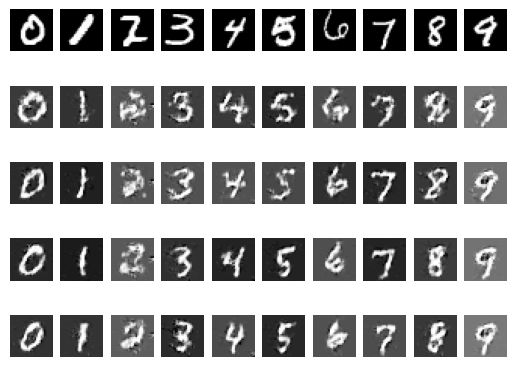

In [14]:
# MNIST 데이터셋 실제 샘플들 및 생성 결과들 저장

original = [ None for _ in range(10) ]

# store original image examples
stop = False
for iter, (image_batch, label_batch) in enumerate(test_dataloader):
    for image, label in zip(image_batch, label_batch):

        label = label.item()

        if original[label] is None:
            original[label] = image.data

        if None not in original:
            stop = True
            break

    if stop: break

z_noise = torch.randn(1, 128).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result1 = generate_images(g_model, z_noise, class_label).cpu().detach().numpy() # from noise 1

z_noise = torch.randn(1, 128).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result2 = generate_images(g_model, z_noise, class_label).cpu().detach().numpy() # from noise 2

z_noise = torch.randn(1, 128).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result3 = generate_images(g_model, z_noise, class_label).cpu().detach().numpy() # from noise 3

z_noise = torch.randn(1, 128).repeat(10, 1) # 동일 노이즈
class_label = torch.tensor([ n for n in range(10) ])
result4 = generate_images(g_model, z_noise, class_label).cpu().detach().numpy() # from noise 4


# MNIST 데이터셋 실제 샘플들 및 생성 결과들 시각화

image_dim=28
fig, ax = plt.subplots(nrows=5, ncols=10)

for i, image in enumerate(original):
    plt.subplot(5, 10, 1*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result1):
    plt.subplot(5, 10, 2*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result2):
    plt.subplot(5, 10, 3*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result3):
    plt.subplot(5, 10, 4*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

for i, image in enumerate(result4):
    plt.subplot(5, 10, 5*10-(9-i))
    plt.imshow(image.reshape(image_dim, image_dim), cmap="gray")
    plt.axis("off")

plt.show()